# This is to choose N random files from the barmak dataset in order to test the thresholding pipeline

In [11]:
# from https://stackoverflow.com/a/52586317

import os, random, shutil

#Prompting user to enter number of files to select randomly along with directory
source = "/Users/fabianprofeta/Desktop/PDS-IR-imaging/IR-imaging-2024/barmak/5_cluster_contour_ilastik/observation/imgs10"
dest = "/Users/fabianprofeta/Desktop/PDS-IR-imaging/IR-imaging-2024/thresholding/imgs_samples"
no_of_files = 50

print("%"*25+"{ Details Of Transfer }"+"%"*25)
print("\n\nList of Files Moved to %s :-"%(dest))

#Using for loop to randomly choose multiple files
for i in range(no_of_files):
    #Variable random_file stores the name of the random file chosen
    random_file=random.choice(os.listdir(source))
    print("%d} %s"%(i+1,random_file))
    source_file=source + "/" + random_file 
    dest_file=dest
    #"shutil.move" function moves file from one directory to another
    shutil.move(source_file,dest_file)
    os.rename(dest_file+"/"+random_file, dest_file+"/img"+str(i)+".jpg")

print("\n\n"+"$"*33+"[ Files Moved Successfully ]"+"$"*33)

%%%%%%%%%%%%%%%%%%%%%%%%%{ Details Of Transfer }%%%%%%%%%%%%%%%%%%%%%%%%%


List of Files Moved to /Users/fabianprofeta/Desktop/PDS-IR-imaging/IR-imaging-2024/imgs_samples :-
1} vid_hive4_rpi2_201205-010001-utc.jpg
2} vid_hive4_rpi2_201204-235001-utc.jpg
3} vid_hive4_rpi2_201203-013001-utc.jpg
4} vid_hive4_rpi2_201206-023001-utc.jpg
5} vid_hive4_rpi2_201203-035001-utc.jpg
6} vid_hive4_rpi2_201203-144001-utc.jpg
7} vid_hive4_rpi2_201205-105001-utc.jpg
8} vid_hive4_rpi2_201206-033001-utc.jpg
9} vid_hive4_rpi2_201201-191001-utc.jpg
10} vid_hive4_rpi2_201202-120001-utc.jpg
11} vid_hive4_rpi2_201206-121001-utc.jpg
12} vid_hive4_rpi2_201202-172001-utc.jpg
13} vid_hive4_rpi2_201206-014001-utc.jpg
14} vid_hive4_rpi2_201202-112001-utc.jpg
15} vid_hive4_rpi2_201203-025001-utc.jpg
16} vid_hive4_rpi2_201204-102001-utc.jpg
17} vid_hive4_rpi2_201204-203001-utc.jpg
18} vid_hive4_rpi2_201204-175001-utc.jpg
19} vid_hive4_rpi2_201205-174001-utc.jpg
20} vid_hive4_rpi2_201206-175001-utc.jpg
21} vid_hive4_

# -----------------------------------------------------------------------------

# We test here the pipeline on N random files

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes, remove_small_objects, disk, opening, closing
import glob
import time

In [6]:
folder_in = 'imgs_samples/'
images = sorted(glob.glob(folder_in + '*.jpg'))
imgs = []

for image in images:
    img = cv2.imread(image)
    imgs.append(img)

In [88]:
imgs = [cv2.imread('img2.jpg')]

thresholds= np.ones([len(imgs)]) * 80
imgs_tmp = []
times = []

for img, threshold in zip(imgs, thresholds):
    start_time = time.time()
    img_tmp = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) #histogram equalization
    img_tmp = cv2.GaussianBlur(img_tmp, (7, 7), 0) #blur cause it never caused any harm
    _, img_tmp = cv2.threshold(img_tmp, threshold, 255, cv2.THRESH_BINARY) #thresholding
    imgs_tmp.append(img_tmp)
    times.append(round(time.time() - start_time, 2))
print('Average time taken: ', round(sum(times) / len(times), 2), 's')

Average time taken:  0.03 s


In [89]:
imgs_tmp1000_oc = []
n = 0
times = []
for img_tmp in imgs_tmp:
    start_time = time.time()
    # some morphological operations (this take lil bit of time)
    img_tmp1000 = remove_small_objects(img_tmp, min_size=1000); #remove small objects
    img_tmp1000_rem = remove_small_holes(img_tmp1000, area_threshold=1000); #remove small holes
    img_tmp1000_oc = closing(opening(img_tmp1000_rem, disk(7)), disk(7)) #open then close the mask (small disk cause takes time)
    imgs_tmp1000_oc.append(~img_tmp1000_oc)
    # to save time in the future, save the masks
    cv2.imwrite('imgs_samples_mask/mask'+str(n)+'.jpg', ~img_tmp1000_oc * 255)
    times.append(round(time.time() - start_time, 2))
    n += 1
print('Average time taken: ', round(sum(times) / len(times), 2), 's')

/var/folders/81/88qz8hc518d6msz681nh39mm0000gn/T/ipykernel_73577/240072987.py:8: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  img_tmp1000_rem = remove_small_holes(img_tmp1000, area_threshold=1000); #remove small holes


Average time taken:  8.57 s


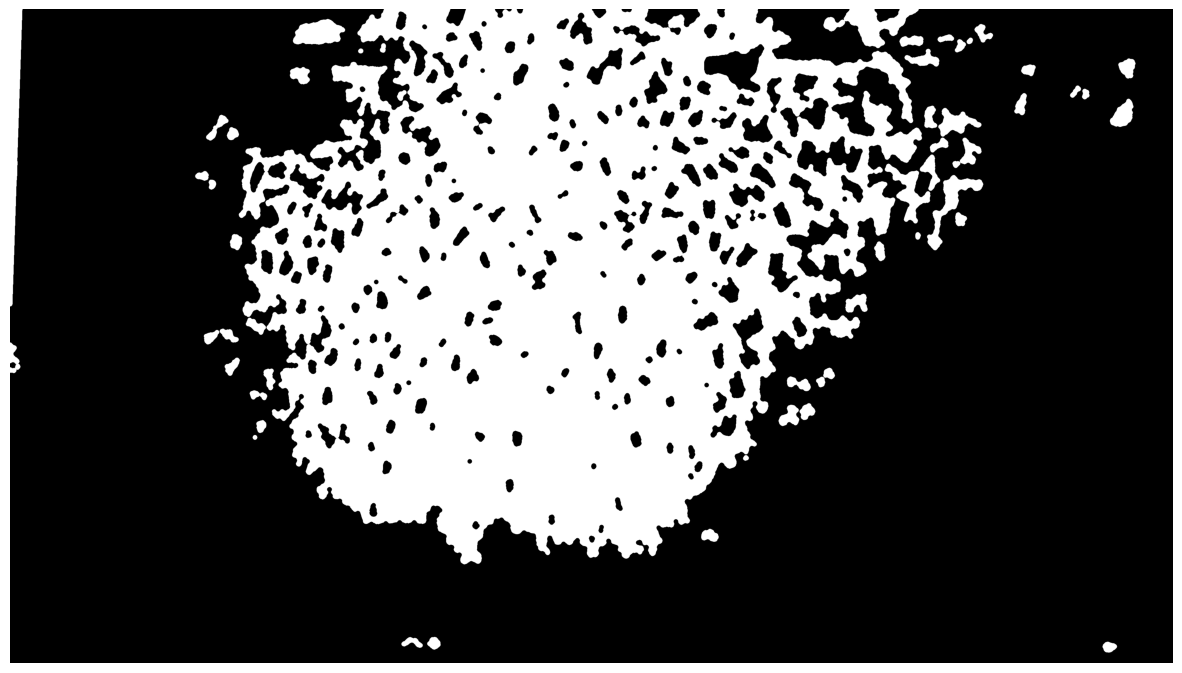

In [90]:
# we load mask that were preprocessed to save time on morphological operations if we dont want to redo them
masks = []
no_of_file = 1
for n in range(no_of_file):
    mask = cv2.imread('imgs_samples_mask/mask'+str(n)+'.jpg', cv2.IMREAD_GRAYSCALE)
    masks.append(mask)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(mask, cmap='gray')
    ax.axis('off')
    # ax.set_title('Thresholding - Mask after morphological operations')
    plt.show()

# mask = masks[0]

In [91]:
# now we can find the contours
n = 0

for mask, input_image in zip(masks, imgs):
    img_contour = (mask).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
    contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
    contour = max(contours, key=cv2.contourArea) #get the biggest contour
    img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
    cv2.drawContours(input_image, contour, -1, (255, 0, 0), 14) #draw the biggest contour

    # find the centroid of the contour
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # plot it on the image
    cv2.circle(input_image, (cX, cY), 20, (255, 0, 0), -1)
    cv2.putText(input_image, "centroid", (cX, cY - 60), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 8)

    ellipse = cv2.fitEllipse(contour)
    cv2.ellipse(input_image, ellipse, color=(0,255,0), thickness=5)
    cv2.imwrite('imgs_samples_contour/contour' + str(n) + '.jpg', cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    n += 1

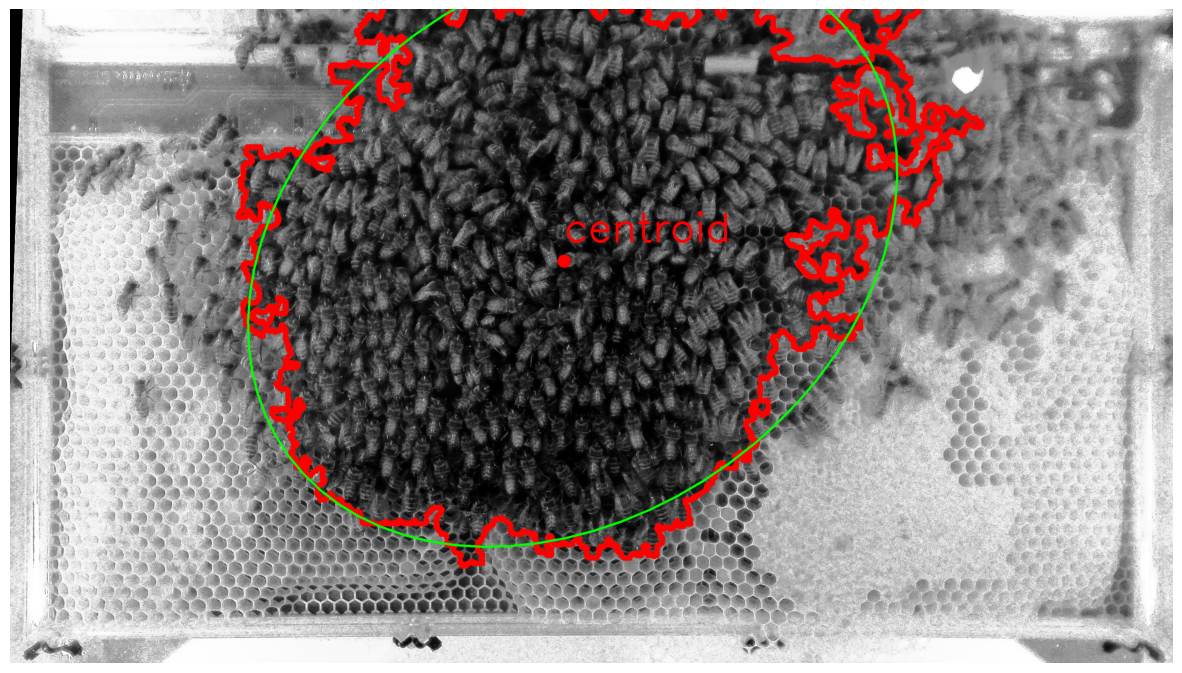

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(input_image, cmap='gray')
ax.axis('off')
# ax.set_title('Thresholding - Centroid, Contour and best fitted Ellipse')
plt.show()